# LSTM Time Series Forecasting

This jupyter-notebook is based on a tutorial at https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/.

This example uses LSTM for international airline passengers.

In [10]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# without loading the col 0, only col 1
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

print(dataset[:5])

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]]


In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	# look_back: the number of previous time steps to use as input variables to predict the next time period
	# if you want to predict current passenger # based on two time stamps back, look_back should be 2
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 - 2s - 26ms/step - loss: 0.0485
Epoch 2/100
94/94 - 0s - 2ms/step - loss: 0.0238
Epoch 3/100
94/94 - 0s - 2ms/step - loss: 0.0178
Epoch 4/100
94/94 - 0s - 2ms/step - loss: 0.0162
Epoch 5/100
94/94 - 0s - 2ms/step - loss: 0.0153
Epoch 6/100
94/94 - 0s - 3ms/step - loss: 0.0142
Epoch 7/100
94/94 - 0s - 2ms/step - loss: 0.0132
Epoch 8/100
94/94 - 0s - 2ms/step - loss: 0.0122
Epoch 9/100
94/94 - 0s - 2ms/step - loss: 0.0111
Epoch 10/100
94/94 - 0s - 2ms/step - loss: 0.0100
Epoch 11/100
94/94 - 0s - 3ms/step - loss: 0.0091
Epoch 12/100
94/94 - 0s - 2ms/step - loss: 0.0080
Epoch 13/100
94/94 - 0s - 2ms/step - loss: 0.0071
Epoch 14/100
94/94 - 0s - 3ms/step - loss: 0.0062
Epoch 15/100
94/94 - 0s - 2ms/step - loss: 0.0054
Epoch 16/100
94/94 - 0s - 2ms/step - loss: 0.0048
Epoch 17/100
94/94 - 0s - 2ms/step - loss: 0.0040
Epoch 18/100
94/94 - 0s - 2ms/step - loss: 0.0035
Epoch 19/100
94/94 - 0s - 2ms/step - loss: 0.0031
Epoch 20/100
94/94 - 0s - 2ms/step - loss: 0.0028
Epoch 21/100
94/94 -

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX) # COMPLETED make predictions for the testing data
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict) # COMPLETED use scaler.inverse_transform to inverse the transformation
trainY = scaler.inverse_transform([trainY]) # COMPLETED use scaler.inverse_transform to inverse the transformation
testPredict = scaler.inverse_transform(testPredict) # COMPLETED use scaler.inverse_transform to inverse the transformation
testY = scaler.inverse_transform([testY]) # COMPLETED use scaler.inverse_transform to inverse the transformation
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 23.49 RMSE
Test Score: 50.28 RMSE


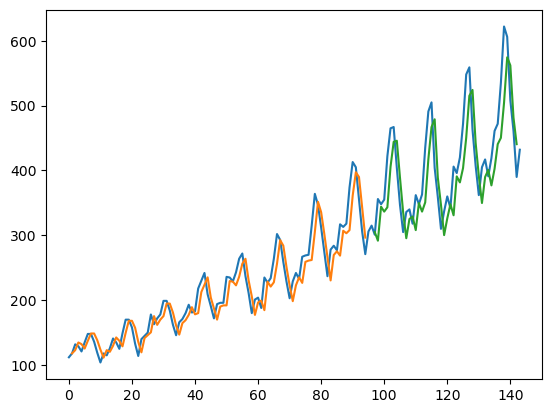

In [15]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()